In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [3]:
temp = np.loadtxt("Temp_Aachen_2018.csv", delimiter=",")[:,1]

In [4]:
# Define some helper variables
n = 1000
days = 365
z = np.linspace(0,20, n)
year = np.arange(days)

# Define parameters of function
Tm = np.mean(temp)
Td = 9
omega = 2*np.pi/days
phi = np.pi * 0.85

T_s = Tm + Td * np.cos(omega*year + phi)

# Calculate fit
RMSE = np.sqrt(((T_s - temp)**2).mean())

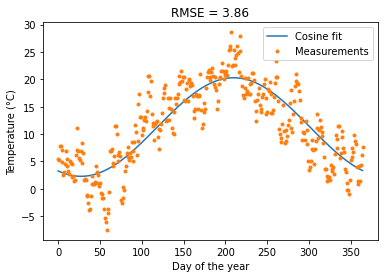

In [5]:
# Visualize result
plt.plot(year, T_s, label="Cosine fit")
plt.plot(year, temp,'.', label="Measurements")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.title("RMSE = %.2f" % RMSE)
plt.legend()

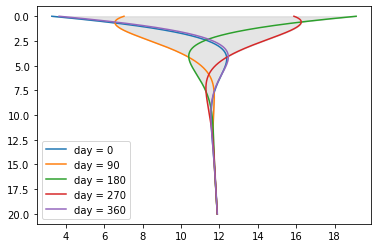

In [6]:
kappa = 0.5e-6 * 60 * 60 * 24
mt = []
fig, ax = plt.subplots()

for t in year[::90]:
    T = Tm + 0.03*z + Td * np.exp(-np.sqrt(omega/(2*kappa)) * z) * np.cos(omega*t - np.sqrt(omega/(2*kappa)) * z + phi)
    mt.append(T)
    ax.plot(T, z, label="day = %d" % t)
    
ax.invert_yaxis()
mt = np.array(mt)
ax.legend()
ax.fill_betweenx(z, np.min(mt, axis=0), np.max(mt, axis=0), alpha=0.1, color="k")

### References
- Carslaw, H. S., and J. C. Jaeger, 1959: Conduction of Heat in Solids.
2nd ed. Oxford University Press, 510 pp.

To make the problem suitable for optimization, we need a function with parameters and a return value that should be minimized.

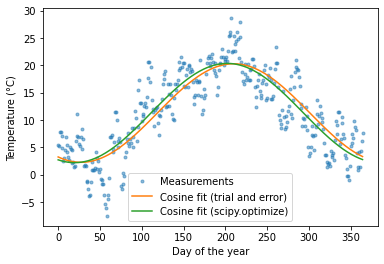

In [7]:
def func(params):
    Tm, Td, phi = params
    omega = 2*np.pi/days
    T_s = Tm + Td * np.cos(omega*year + phi)
    RMSE = np.sqrt(((T_s - temp)**2).mean())
    return RMSE

from scipy.optimize import minimize
params = Tm, Td, phi # initial guess
result = minimize(func, params)

Tm_opt, Td_opt, phi_opt = result.x
T_s_opt = Tm_opt + Td_opt * np.cos(omega*year + phi_opt)

plt.plot(year, temp,'.', label="Measurements", alpha=0.5)
plt.plot(year, T_s, label="Cosine fit (trial and error)")
plt.plot(year, T_s_opt, label="Cosine fit (scipy.optimize)")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.legend()

In [8]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))

def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
HTML(ani.to_html5_video())
plt.clf()

<Figure size 432x288 with 0 Axes>

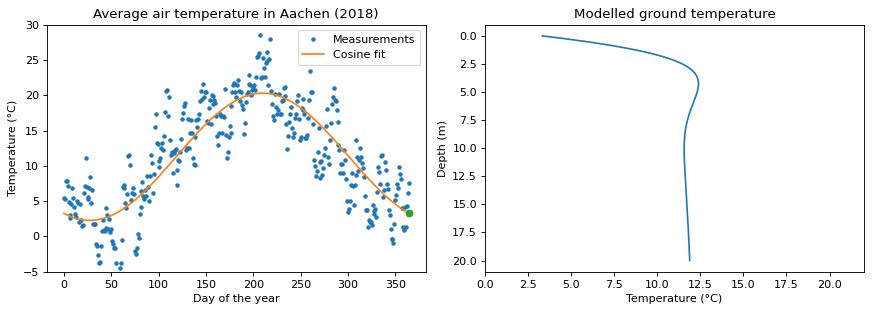

In [9]:
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4), dpi=80)
ax1.set_title("Average air temperature in Aachen (2018)")
ax2.set_title("Modelled ground temperature")
ax1.set_xlabel("Day of the year")
ax1.set_ylabel("Temperature (°C)")
ax2.set_xlabel("Temperature (°C)")
ax2.set_ylabel("Depth (m)")
ax2.set_xlim(0,22)
ax1.plot(year, temp,'.', label="Measurements")
ax1.plot(year,T_s, label="Cosine fit")
vline, = ax1.plot(0, T[0], "o", color="tab:green", ms=6)
ax1.set_ylim(-5,30)
ax1.legend()

T = Tm + 0.03*z + Td * np.exp(-np.sqrt(omega/(2*kappa)) * z) * np.cos(- np.sqrt(omega/(2*kappa)) * z + phi)
line, = ax2.plot(T, z)
ax2.invert_yaxis()

# initialization function: plot the background of each frame
def init():
    line.set_data(T, z)
    vline.set_data(0,T[0])
    return line, vline,

# animation function. This is called sequentially
def animate(i):
    t = i
    T = Tm + 0.03*z + Td * np.exp(-np.sqrt(omega/(2*kappa)) * z) * np.cos(omega*t - np.sqrt(omega/(2*kappa)) * z + phi)
    line.set_data(T, z)
    vline.set_data(i, T[0])
    return line, vline,

fig.tight_layout()

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=365, interval=20, blit=True)
HTML(anim.to_html5_video())
#anim.save("animation.gif", writer="imagemagick")